# Solving Linear Systems with Python
In the following we want to learn how to use `numpy` and `scipy` to solve Linear Systems with Python. The majority of the functions in `numpy` and `scipy` for Numerical Linear Algebra are contained in the sub-packages `np.linalg` and `scipy.linalg`.

As a general rule, remember that `np.linalg` contains all the basic functions to run NLA algorithms, while `scipy` mostly focus on efficiency, implementing algorithms such as fast linear system solvers, memory efficient matrix memorization, ... 

To fix the notation, consider a matrix $A \in \mathbb{R}^{n \times n}$ and a vector $y \in \mathbb{R}^n$. **Solving** a linear system means finding (when exists) a vector $x \in \mathbb{R}^n$ such that it satisfies

$$
    Ax = y.
$$

Clearly, a trivial solution to this problem is to compute the inverse of $A$ by using the function `np.linalg.inv()`, and then multiplying it by $y$ to obtain the solution:

$$
    x = A^{-1} y.
$$

However, we already remarked that this is unfeasible for large matrices $A$, since the computation of the inverse of a matrix requires $O(n!)$ operations, which grows insanely fast.

> **Exercise:** Implement a Python function taking as input a non-singular matrix $A \in \mathbb{R}^{n \times n}$, a datum $y \in \mathbb{R}^n$, and returning the solution to the linear system $Ax = y$, by multiplying $A^{-1}$ to $y$. This approach is usually referred to as **direct solution**. Check the time required to run this algorithm by defining the matrix $A$ as a matrix of all ones with dimension $n \times n$, $y$ being the vector of all ones, with increasing values of $n$ from 1 to 30.

As you can see from the exercise above, computing the solution of a linear system requires a lot of time even for relatively small matrices. The computational time required to solve the system can be lowered from $O(n!)$ to $O(n^3)$ by using a very efficient algorithm.

This is easy to do in `numpy`, since it implements a function `np.linalg.solve`, taking as input a 2-dimensional array `A` and a 1-dimensional array `y`, and returning the solution `x` to the linear system. In particular:

In [1]:
import numpy as np

# Generates the problem
A = np.array([[1, 1, 1], [2, 1, 2], [0, 0, 1]])
y = np.array([0, 1, 0])

# Solve the system
x_sol = np.linalg.solve(A, y)
print(f"The solution is {x_sol}.")

The solution is [ 1. -1.  0.].


### Testing the accuracy
You should already know that a big limitation of any computational device is the **floating point system**. Indeed, the way of representing numbers by their mantissa+exponent decomposition, allows for a very efficient representation, but clearly not every floating point number is representable. For example, you already studied the concept of machine precision $\epsilon$, i.e. the smallest number such that

$$
fl(1 + \epsilon) > fl(1).
$$

As a consequence, a number such as $1 + \frac{\epsilon}{2}$ cannot be represented by computers, since it is indistinguishable from 1.

This problem becomes particularly intense when one wants to encode real numbers such as $\pi$ or the Nepero number $e$. Therefore, when we work with any algorithm which is implemented on a computational device, we always need to assume that the representation has some error. As a notation, we denote as $\tilde{A}$ the machine representation of a matrix $A$, and by $\delta A := \tilde{A} - A$ the representation error. The same notation applies for vectors $x$ and $y$ representing the right-hand side of a linear system and its solution, respectively. 

An important aspect of developing NLA algorithm is to study how representation errors in the measurement matrix $A$ and known-term $y$ get **amplified** (or **shrinked**) in the solution $x$ (i.e. to compute $\delta x$ as a function of $\delta A$ and $\delta y$). In particular, we usually care about the **relative** error, which is simpler to compute in most of the cases, and it does not depend on the measuring unit of the quantities.

In particular, the relative error between the true solution $x_{true}$ and the computed solution $x_{sol}$ is defined as:

$$
    E(x_{true}, x_{sol}) := \frac{|| x_{true} - x_{sol} ||_2}{|| x_{true} ||_2} = \frac{|| \delta x ||_2}{|| x_{true} ||_2}.
$$

However, to compute the relative error of a computed solution $x_{sol}$, we first need to know the **true** solution $x_{true}$, which is usually not the case in a real scenario. How can we achieve it? 

A common solution, which we will use for the whole course, is to verify the performance of the algorithm by building a **test problem**, i.e. a problem of which we know the true solution *by construction*.

### Creating a Test Problem
Consider a matrix $A \in \mathbb{R}^{n \times n}$ and assume we want to test the accuracy of an algorithm solving systems involving $A$. Let us fix an $n$-dimensional vector $x_{true} \in \mathbb{R}^n$, and compute $y = Ax_{true}$. Clearly, this procedure defines a linear system

$$
    Ax = y
$$

of which we know that $x_{true}$ is a **solution by construction**, since we built the term $y$ accordingly. Now, when we apply our algorithm to that linear system, we get a solution $x_{sol}$, which is in general different from $x_{true}$, due to the amplification of the errors coming from the numerical representation of $A$. Since we defined the system such that $x_{true}$ is the true solution, we can compute the relative error $E(x_{true}, x_{sol})$ associated to the solution obtained by the algorithm, and quantify how the algorithm performed in terms of error amplification. 

Let us see how we can build a test problem in Python, to test the accuracy of the classical linear system solver algorithm `np.linalg.solve`.

In [2]:
import numpy as np

# Setting up the dimension
n = 15

# Creating the test problem (with a Random matrix)
A = np.random.randn(n, n) # n x n random matrix
x_true = np.ones((n, ))   # n-dimensional vector of ones

y = A @ x_true # Compute the term y s.t. x_true is a sol.

# Solving the system with numpy
x_sol = np.linalg.solve(A, y)

# Computing the accuracy
E_rel = np.linalg.norm(x_true - x_sol, 2) / np.linalg.norm(x_true, 2)
print(f"The relative error is {E_rel}")

The relative error is 6.451086838739376e-15


As you can see, the error is very small. This is due to two aspects of the problem:

1. The algorithm is **stable** (i.e. it does not amplify the errors on $A$)
2. The matrix $A$ il "well-behaved", i.e. its inverse does not amplifies the errors on $y$. We say that $A$ is **well-conditioned**, as opposed to **ill-conditioned** matrices.

Let us check what happens when we apply the same, stable algorithm, to solve a linear system where the matrix $A$ is ill-conditioned, such as the `hilbert` matrix (available from the `scipy` package).

In [3]:
import numpy as np
import scipy
import scipy.linalg

# Setting up the dimension
n = 15

# Creating the test problem (with Hilbert matrix)
A = scipy.linalg.hilbert(n) # n x n hilbert matrix
x_true = np.ones((n, ))   # n-dimensional vector of ones

y = A @ x_true # Compute the term y s.t. x_true is a sol.

# Solving the system with numpy
x_sol = np.linalg.solve(A, y)

# Computing the accuracy
E_rel = np.linalg.norm(x_true - x_sol, 2) / np.linalg.norm(x_true, 2)
print(f"True solution: {x_true}.")
print(f"Computed solution: {x_sol}.")
print(f"The relative error is {E_rel}")

True solution: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.].
Computed solution: [ 0.99999995  1.00000807  0.99967264  1.00577502  0.94490775  1.31657382
 -0.15652389  3.72666552 -3.00357812  4.04053468  1.3253252  -2.17033528
  4.1161354  -0.39618677  1.25102602].
The relative error is 1.9326759080352935


This example shows a fundamental concept in Numerical Linear Algebra: using a stable algorithm does **NOT guarantee** that that solution to the problem is accurate. Indeed, if the system matrix $A$ is ill-conditioned, then there is **no algorithm** which is able to obtain an accurate solution.

In the following section, we investigate in more detail the meaning of conditioning for a linear operator.

### Condition number
When the matrix $A$ is ill-conditioned, the solution of a linear system will not be accurate, since the small perturbations on $y$ introduced by the floating point system will be amplified and the corresponding solution will be drammatically distant from the true solution.

How can we quantify the conditioning of a matrix? And how can we define a matrix to be ill-conditioned?

To quantify conditioning of an $n \times n$ matrix $A$, it is common to consider the **condition number** which, whenever $A$ is invertible, is defined as:

$$
    k_p(A) = ||A||_p || A^{-1} ||_p
$$

Where $p \geq 1$ idenfities the norm on which the condition number is computed. Due to the equivalence of norms, the **magnitude** of the condition number does not depend of $p$ (i.e. the magnitude of $k_p(A)$ should be approximately the same, whatever is the value of $p$). For this reason, it is typical to measure the condition number of a matrix by setting $p=2$.

To compute the $p$-condition number of a matrix $A$ in `numpy`, you can use the function `np.linalg.cond(A, p)`.

For example, let us check the condition number of the random matrix vs the condition number of the hilbert matrix.

In [4]:
import numpy as np
import scipy
import scipy.linalg

# Setting up the dimension
n = 15

# Creating the test problem (with Hilbert matrix)
A_random = np.random.randn(n, n) # n x n random matrix
A_hilbert = scipy.linalg.hilbert(n) # n x n hilbert matrix

print(f"Cond. Number Random matrix: {np.linalg.cond(A_random, p=2)}")
print(f"Cond. Number Hilbert matrix: {np.linalg.cond(A_hilbert, p=2)}")

Cond. Number Random matrix: 77.36597472127144
Cond. Number Hilbert matrix: 2.3228053763031325e+17


As you can see, the condition number of Hilbert matrix is insanely higher than the condition number of random matrix, a fact which explains why the relative error while using the Hilbert matrix is higher than when using the random matrix.

Now, where do we set the threshold on the condition number to define an operator to be **ill-conditioned** versus it being **well-conditioned**? Let us check an interesting property of the condition number.

Condition number for n = 1: 1.0.
Condition number for n = 2: 19.281470067903967.
Condition number for n = 3: 524.0567775860627.
Condition number for n = 4: 15513.738738929662.
Condition number for n = 5: 476607.2502419222.
Condition number for n = 6: 14951058.641931808.
Condition number for n = 7: 475367356.51983196.
Condition number for n = 8: 15257576052.786306.
Condition number for n = 9: 493153909929.7127.
Condition number for n = 10: 16024897439077.97.
Condition number for n = 11: 521959222338558.8.
Condition number for n = 12: 1.6360718665566702e+16.


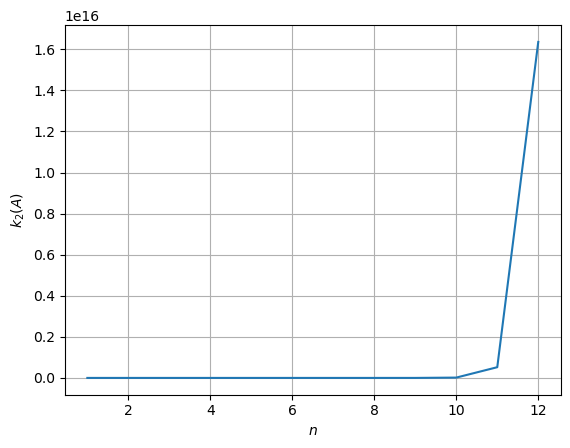

In [5]:
# We want to print out the condition number of the hilbert matrix A 
# for increasing dimension
n_max = 12

condition_numbers = np.zeros((n_max, ))
for n in range(1, n_max+1):
    # Define the hilbert matrix
    A = scipy.linalg.hilbert(n)

    # Compute the condition number
    cond = np.linalg.cond(A, p=2)

    # Print and save
    print(f"Condition number for n = {n}: {cond}.")
    condition_numbers[n-1] = cond # "n-1" because range begins by 1!

# Plot the condition number in semilogy plot
import matplotlib.pyplot as plt
plt.plot(np.arange(1, n_max+1), condition_numbers)
plt.grid()
plt.xlabel(r"$n$")
plt.ylabel(r"$k_2(A)$")
plt.show()

As you can see, the condition number starts relatively small, then grows exponentially for increasing values of $n$.

This is not a coincidence. Indeed, the condition number of basically every matrix **grows with the dimensionality**! As a consequence, the threshold defining an ill-conditioned matrix should depend on $n$.

This observation justifies the following definition:

> An invertible matrix $A$ is said to be **ill-conditioned** if its condition number grows exponentially with the dimension of the problem, $n$, i.e. if $k_2(A) \approx c10^{n}$ for a positive constant $c>0$.

While:

> An invertible matrix $A$ is said to be **well-conditioned** if its condition number grows linearly with the dimension of the problem, $n$, i.e. if $k_2(A) \approx cn$ for a positive constant $c>0$.

This can be checked by simply plotting the behavior of the condition number in `semilogy` scale. If the plot appears to be a straight line, then $A$ is ill-conditioned, otherwise, it is well-conditioned.

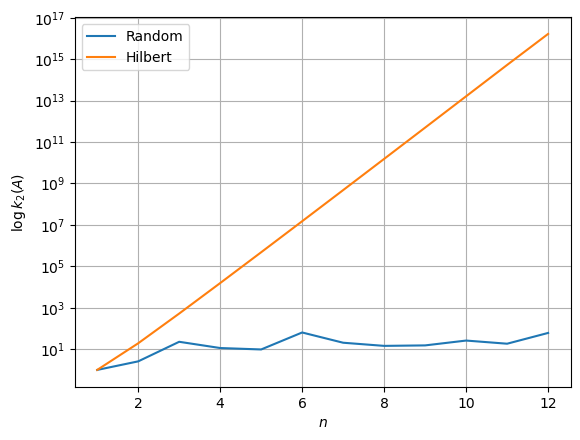

In [6]:
# We want to print out the condition number of the hilbert matrix vs random matrix
# for increasing dimension
n_max = 12

condition_numbers_rand = np.zeros((n_max, ))
condition_numbers_hilb = np.zeros((n_max, ))
for n in range(1, n_max+1):
    # Define the hilbert matrix
    A_rand = np.random.randn(n, n)
    A_hilb = scipy.linalg.hilbert(n)

    # Compute the condition number
    cond_rand = np.linalg.cond(A_rand, p=2)
    cond_hilb = np.linalg.cond(A_hilb, p=2)

    # Print and save
    condition_numbers_rand[n-1] = cond_rand # "n-1" because range begins by 1!
    condition_numbers_hilb[n-1] = cond_hilb # "n-1" because range begins by 1!

# Plot the condition number in semilogy plot
import matplotlib.pyplot as plt
plt.semilogy(np.arange(1, n_max+1), condition_numbers_rand)
plt.semilogy(np.arange(1, n_max+1), condition_numbers_hilb)
plt.grid()
plt.xlabel(r"$n$")
plt.ylabel(r"$\log k_2(A)$")
plt.legend(["Random", "Hilbert"])
plt.show()

How can we relate the condition number of a matrix with the accuracy of the solution to a linear system associated with it?

Consider the following inequality:

$$
    \frac{|| \delta x ||}{||x||} \leq k_2(A) \Bigl( \frac{||\delta A||}{|| A ||} + \frac{|| \delta y ||}{|| y ||} \Bigr).
$$

It implies that the relative error on the computed solution is big whenever $k_2(A)$ is big. Moreover, note that as a consequence of the formula above, the accuracy of a computed solution is partially a property of the condition number of $A$ itself, meaning that (again) **no algorithm** is able to compute an accurate solution to an ill-conditioned system.

### Solving Linear System by Matrix Splitting
As you should know, when the matrix $A$ is unstructured, the linear system $Ax = y$ can be efficiently solved by using [LU Decomposition](https://en.wikipedia.org/wiki/LU_decomposition). In particular, with Gaussian elimination algorithm, one can factorize any non-singular matrix $A \in \mathbb{R}^{n \times n}$ into:

$$
    A = PLU
$$

where $L \in \mathbb{R}^{n \times n}$ is a lower-triangular matrix, $U \in \mathbb{R}^{n \times n}$ is an upper-triangular matrix with all ones on the diagonal and $P \in \mathbb{R}^{n \times n}$ is a permutation matrix (i.e. a matrix obtained by permutating the rows of the identity matrix). If the decomposition is computed without pivoting, the permutation matrix equals the identity. Note that the assumption that $A$ is non-singular is not restrictive, since it is a necessary condition for the solvability of $Ax = y$. 

Since $P$ is an orthogonal matrix, $P^{-1} = P^T$, thus

$$
    A = PLU \iff P^T A = LU
$$

Since linear systems of the form 

$$
    Lx = y \quad \text{ and } \quad Ux = y
$$

can be efficiently solved by the Forward (Backward) substitution, and the computation of the LU factorization by Gaussian elimination is pretty fast ($O(n^3)$ floating point operations), we can use that to solve the former linear system. 

Indeed,

$$
    Ax = y \iff P^TAx = P^Ty \iff LUx = P^Ty
$$

then, by Forward-Backward substitution, this system can be solved by subsequently solving 

$$
    Lz = P^Ty \quad \text{ then } \quad Ux = z
$$

whose solution is a solution for $Ax = y$.

Even if this procedure is automatically performed by the `np.linalg.solve` function, we can unroll it with the functions `scipy.linalg.lu(A)` and `scipy.linalg.solve_triangular(A, b)`, whose documentation can be found [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.lu.html) and [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.solve_triangular.html).

> **_Exercise:_** Write a function that takes as input a non-singular matrix $A \in \mathbb{R}^{n \times n}$ and a vector $y \in \mathbb{R}^n$ and returns the solution $x \in \mathbb{R}^n$ of $Ax = y$, with the `np.linalg.solve` and the `scipy.linalg.lu()` + `scipy.linalg.solve_triangular()` functions. Compare the time required for the two algorithms when $A$ is a random matrix of dimension $n = 1000$, while $y$ is the datum built such that $x_{true}$ is the vector of all ones. Check the reconstruction errors in the two cases. 

### Cholesky factorization
If the matrix $A$ is SDP (symmetric and positive definite), then we can halve the number of operations required to compute the solution to the system by considering the Cholesky decomposition, which factorizes $AA$ as:

$$
A = L L^T
$$

where $L$ is a non-singular lower-triangular matrix. Then, we can simply use the forward-backward algorithm to solve the system $Ax = y$. 

The Cholesky decomposition can be computed in Python with the command `np.linalg.cholesky`.

Since it holds the following result:

> **Theorem:** A square matrix $A$ is SDP **if and only if** it admits a Cholesky decomposition,

the function `np.linalg.cholesky` can be also used to check if a matrix $A$ is SDP.

> **Exercise:** Repeat the same exericise as before, setting $A$ to be the Hilbert matrix, $n=10$, $x_{true}$ is the vector of all ones. Check the accuracy and the time required by computing the solution with:
> - The built-in `numpy` function.
> - The LU decomposition (with `scipy`) with `solve_triangular`.
> - The Cholesky decomposition with `solve_triangular`.